In [1]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# Load the datasets
customers_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagements_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

In [2]:
## DATA CLEANING

In [3]:
# Convert date columns to datetime
customers_df['join_date'] = pd.to_datetime(customers_df['join_date'])
customers_df['last_purchase_date'] = pd.to_datetime(customers_df['last_purchase_date'])
marketing_df['campaign_date'] = pd.to_datetime(marketing_df['campaign_date'])
transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])

In [4]:
# Define the cutoff date
cutoff_date = pd.to_datetime('2024-05-31')

# Convert dates later than 5/31/2024 to 5/31/2024
customers_df['join_date'] = customers_df['join_date'].apply(lambda x: x if x <= cutoff_date else cutoff_date)
customers_df['last_purchase_date'] = customers_df['last_purchase_date'].apply(lambda x: x if x <= cutoff_date else cutoff_date)
marketing_df['campaign_date'] = marketing_df['campaign_date'].apply(lambda x: x if x <= cutoff_date else cutoff_date)
transactions_df['transaction_date'] = transactions_df['transaction_date'].apply(lambda x: x if x <= cutoff_date else cutoff_date)

In [5]:
# Merging
# Aggregate marketing responses
marketing_agg = marketing_df.groupby('customer_id')['response'].value_counts().unstack(fill_value=0).reset_index()
marketing_agg.columns = ['customer_id', 'no_response', 'yes_response']

# Aggregate transaction data
transactions_agg = transactions_df.groupby('customer_id').agg(
    total_transaction_amount=pd.NamedAgg(column='transaction_amount', aggfunc='sum'),
    number_of_transactions=pd.NamedAgg(column='transaction_id', aggfunc='count')
).reset_index()

# Merge all dataframes
merged_df = customers_df.merge(engagements_df, on='customer_id', how='left') \
                        .merge(marketing_agg, on='customer_id', how='left') \
                        .merge(transactions_agg, on='customer_id', how='left')

# Fill NaN values for no_response and yes_response with 0
merged_df['no_response'] = merged_df['no_response'].fillna(0)
merged_df['yes_response'] = merged_df['yes_response'].fillna(0)

# Fill NaN values for total_transaction_amount and number_of_transactions with 0
merged_df['total_transaction_amount'] = merged_df['total_transaction_amount'].fillna(0)
merged_df['number_of_transactions'] = merged_df['number_of_transactions'].fillna(0)

In [6]:
merged_df.head()

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,no_response,yes_response,total_transaction_amount,number_of_transactions
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,1,3509.48,6
1,2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,2,2,6081.32,9
2,3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,1,1,1454.87,6
3,4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,3,1,7874.68,20
4,5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,4,0,15524.55,24


In [7]:
# Impute 'Unknown' for missing gender values
merged_df['gender'] = merged_df['gender'].fillna('Unknown')

In [8]:
merged_df.head()

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,no_response,yes_response,total_transaction_amount,number_of_transactions
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,1,3509.48,6
1,2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,2,2,6081.32,9
2,3,2021-06-01,2022-11-27,NaN,Unknown,North Latoyatown,192,73,25,1,1,1454.87,6
3,4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,3,1,7874.68,20
4,5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,4,0,15524.55,24


In [9]:
# Impute missing age with KNNImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# Convert date columns to numeric
merged_df['join_date_numeric'] = merged_df['join_date'].astype('int64') // 10**9
merged_df['last_purchase_date_numeric'] = merged_df['last_purchase_date'].astype('int64') // 10**9

# Encode categorical variables
le_gender = LabelEncoder()
merged_df['gender_encoded'] = le_gender.fit_transform(merged_df['gender'])

le_location = LabelEncoder()
merged_df['location_encoded'] = le_location.fit_transform(merged_df['location'])

# Prepare data for KNN imputation
impute_cols = ['age', 'join_date_numeric', 'last_purchase_date_numeric', 'gender_encoded', 'location_encoded', 'number_of_transactions', 'total_transaction_amount']
impute_data = merged_df[impute_cols]

# Perform KNN imputation
knn_imputer = KNNImputer(n_neighbors=5)
imputed_data = knn_imputer.fit_transform(impute_data)

# Assign imputed age values back to the dataframe
merged_df['age'] = imputed_data[:, 0]

# Drop intermediate columns
merged_df = merged_df.drop(columns=['join_date_numeric', 'last_purchase_date_numeric', 'gender_encoded', 'location_encoded'])

In [10]:
## Feature Engineering

In [11]:
# Create AGE-GENDER feature
# Split age into 5 groups: <20, 20-35, 35-50, 50-65, >65
bins = [-np.inf, 20, 35, 50, 65, np.inf]
labels = ['<20', '20-35', '35-50', '50-65', '>65']
merged_df['age_group'] = pd.cut(merged_df['age'], bins=bins, labels=labels)

# Create a new column 'age-gender'
merged_df['age-gender'] = merged_df['age_group'].astype(str) + '-' + merged_df['gender']

In [12]:
# Calculate Recency, Frequency, and Monetary (clv_monthly) Value (RFM) features
import numpy as np

# Define the cutoff date
cutoff_date = pd.to_datetime('2024-05-31')

# Calculate the joined month
merged_df['joined_month'] = ((cutoff_date - merged_df['join_date']).dt.days / 30).astype(int)
merged_df['joined_month'] = merged_df['joined_month'].apply(lambda x: 1 if x == 0 else x)

# Calculate Recency (in months)
merged_df['recency_months'] = (( merged_df['last_purchase_date'] - cutoff_date).dt.days / 30).astype(int)

# Calculate Frequency
merged_df['frequency'] = merged_df['number_of_transactions']

# Calculate Monetary Value (transaction value per month (CLV), clv_monthly)
merged_df['clv'] = merged_df['total_transaction_amount']
merged_df['clv_monthly'] = merged_df['clv'] / merged_df['joined_month']

# Fill any NaN values resulting from zero transactions or other calculations
merged_df['recency_months'] = merged_df['recency_months'].fillna(0)
merged_df['frequency'] = merged_df['frequency'].fillna(0)
merged_df['clv_monthly'] = merged_df['clv_monthly'].fillna(0)

In [13]:
# For marketing and engagement data
# Calculate the number of 'yes_response' per month
merged_df['yes_response_per_month'] = merged_df['yes_response'] / merged_df['joined_month']

# Calculate the number of 'no_response' per month
merged_df['no_response_per_month'] = merged_df['no_response'] / merged_df['joined_month']

# Calculate the number of site visits per month
merged_df['site_visits_per_month'] = merged_df['number_of_site_visits'] / merged_df['joined_month']

# Calculate the number of emails opened per month
merged_df['emails_opened_per_month'] = merged_df['number_of_emails_opened'] / merged_df['joined_month']

# Calculate the number of clicks per month
merged_df['clicks_per_month'] = merged_df['number_of_clicks'] / merged_df['joined_month']

# Calculate the number of 'yes_respons' per emails opened 
merged_df['yes_response_per_emails_opened'] = merged_df['yes_response'] / merged_df['number_of_emails_opened']

# Calculate the number of clicks per emails opened 
merged_df['clicks_per_emails_opened'] = merged_df['number_of_clicks'] / merged_df['number_of_emails_opened']

In [14]:
# use the 80-20 rule, sorting the customer with clv_monthly
# labelling the highest clv_monthly customers who cumulatively contribute 80% of the total monthly clv as 'High-Value'
# other as ‘Low-Value’

# Calculate the cumulative contribution of each customer to the total monthly CLV
merged_df = merged_df.sort_values(by='clv_monthly', ascending=False)
merged_df['cumulative_clv'] = merged_df['clv_monthly'].cumsum()
total_clv = merged_df['clv_monthly'].sum()
merged_df['cumulative_clv_percentage'] = merged_df['cumulative_clv'] / total_clv

# Label customers based on their contribution to the total monthly CLV
merged_df['value_label'] = np.where(merged_df['cumulative_clv_percentage'] <= 0.80, 'High-Value', 'Low-Value')

# Convert CLV_label to binary
merged_df['value_label'] = np.where(merged_df['value_label'] == 'High-Value', 1, 0)

# Drop intermediate columns
merged_df = merged_df.drop(columns=['cumulative_clv', 'cumulative_clv_percentage'])

In [15]:
merged_df.head()

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,no_response,...,clv,clv_monthly,yes_response_per_month,no_response_per_month,site_visits_per_month,emails_opened_per_month,clicks_per_month,yes_response_per_emails_opened,clicks_per_emails_opened,value_label
7015,7016,2024-05-14,2024-05-28,45.0,Unknown,West Karifort,6,1,1,1,...,22364.72,22364.72,0.0,1.0,6.0,1.0,1.0,0.0,1.0,1
6632,6633,2024-05-25,2024-05-28,54.0,Male,Anthonymouth,1,1,1,3,...,21518.15,21518.15,0.0,3.0,1.0,1.0,1.0,0.0,1.0,1
7583,7584,2024-04-20,2024-05-12,24.0,Female,Elizabethton,1,1,1,1,...,21056.06,21056.06,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
8833,8834,2024-04-17,2024-04-22,40.0,Unknown,Georgehaven,1,1,1,1,...,17721.61,17721.61,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1
5825,5826,2024-05-20,2024-05-30,45.0,Male,Aprilport,4,1,1,1,...,17360.68,17360.68,3.0,1.0,4.0,1.0,1.0,3.0,1.0,1


In [16]:
## Model

In [17]:
# split data into X variables and y variable
# Define the y variable
y = merged_df['value_label']

# Define the X variables
X = merged_df[['age-gender', 'recency_months', 'frequency', 'yes_response_per_emails_opened','clicks_per_emails_opened','site_visits_per_month']]

In [18]:
# Create Pipelines and check the F1 socre for each model
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

# Identify numerical and categorical columns
numerical_cols = ['recency_months', 'frequency', 'yes_response_per_emails_opened','clicks_per_emails_opened', 'site_visits_per_month']
categorical_cols = ['age-gender']

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

# Fit and transform the data
X_preprocessed = preprocessor.fit_transform(X)


In [19]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import make_scorer, f1_score
import numpy as np

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.3, random_state=42)

# Define the models
knn = KNeighborsClassifier()
logreg = LogisticRegression(max_iter=1000)
nb = GaussianNB()

# Define the F1 scorer
f1_scorer = make_scorer(f1_score)

# Calculate the mean F1 score for each model using cross-validation
knn_f1 = cross_val_score(knn, X_train, y_train, cv=5, scoring=f1_scorer).mean()
logreg_f1 = cross_val_score(logreg, X_train, y_train, cv=5, scoring=f1_scorer).mean()
nb_f1 = cross_val_score(nb, X_train, y_train, cv=5, scoring=f1_scorer).mean()

print(f'Mean F1 score for KNeighborsClassifier: {knn_f1:.4f}')
print(f'Mean F1 score for LogisticRegression: {logreg_f1:.4f}')
print(f'Mean F1 score for GaussianNB: {nb_f1:.4f}')

Mean F1 score for KNeighborsClassifier: 0.6667
Mean F1 score for LogisticRegression: 0.6963
Mean F1 score for GaussianNB: 0.6550


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
import pandas as pd

# Define the parameter grid for Logistic Regression
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'saga']
}

# Initialize the LogisticRegression
logreg = LogisticRegression(max_iter=1000)

# Perform GridSearchCV
grid_search_logreg = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search_logreg.fit(X_train, y_train)

# Get the best parameters and the best F1 score
best_params_logreg = grid_search_logreg.best_params_
best_f1_score_logreg = grid_search_logreg.best_score_

print(f'Best parameters for Logistic Regression: {best_params_logreg}')
print(f'Best F1 score for Logistic Regression: {best_f1_score_logreg:.4f}')

c:\Users\NeilXu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
175 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\NeilXu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\NeilXu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\NeilXu\

Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1 score for Logistic Regression: 0.7104


Accuracy: 0.8613
Precision: 0.7699
Recall: 0.7165
F1 Score: 0.7423
ROC AUC Score: 0.9279

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      2164
           1       0.77      0.72      0.74       836

    accuracy                           0.86      3000
   macro avg       0.83      0.82      0.82      3000
weighted avg       0.86      0.86      0.86      3000



<Figure size 1000x600 with 0 Axes>

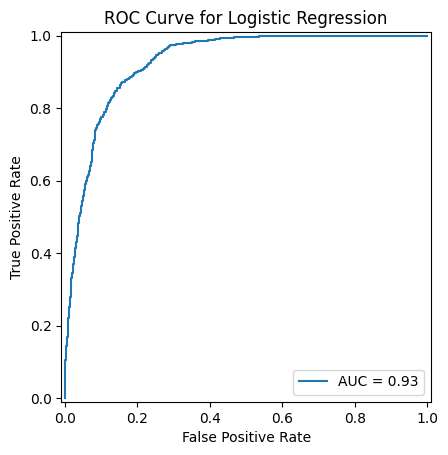

<Figure size 800x600 with 0 Axes>

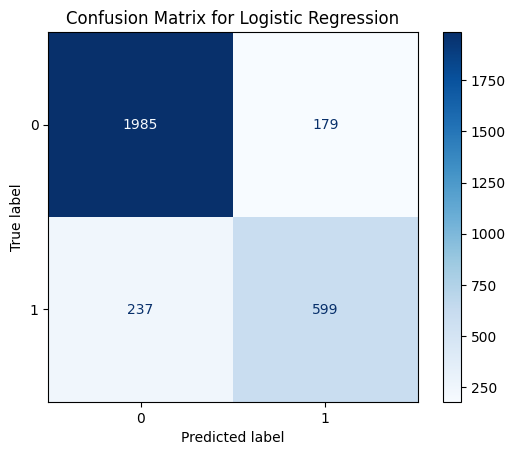

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# Apply the best combination of hyperparameters
best_logreg = LogisticRegression(**best_params_logreg, max_iter=1000)
best_logreg.fit(X_train, y_train)

# Make predictions on the test set
y_pred_logreg = best_logreg.predict(X_test)

# Evaluate the Logistic Regression model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg)
recall_logreg = recall_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, best_logreg.predict_proba(X_test)[:, 1])

# Print the evaluation metrics
print(f'Accuracy: {accuracy_logreg:.4f}')
print(f'Precision: {precision_logreg:.4f}')
print(f'Recall: {recall_logreg:.4f}')
print(f'F1 Score: {f1_logreg:.4f}')
print(f'ROC AUC Score: {roc_auc_logreg:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred_logreg))

# Generate the ROC curve
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, best_logreg.predict_proba(X_test)[:, 1])

# Plot the ROC curve
plt.figure(figsize=(10, 6))
roc_display_logreg = RocCurveDisplay(fpr=fpr_logreg, tpr=tpr_logreg, roc_auc=roc_auc_logreg)
roc_display_logreg.plot()
plt.title('ROC Curve for Logistic Regression')
plt.show()

# Generate the confusion matrix
cm_logreg = confusion_matrix(y_test, y_pred_logreg)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
cm_display_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=best_logreg.classes_)
cm_display_logreg.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

Accuracy: 0.8610
Precision: 0.7280
Recall: 0.8002
F1 Score: 0.7624
ROC AUC Score: 0.9279

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      2164
           1       0.73      0.80      0.76       836

    accuracy                           0.86      3000
   macro avg       0.82      0.84      0.83      3000
weighted avg       0.87      0.86      0.86      3000



<Figure size 1000x600 with 0 Axes>

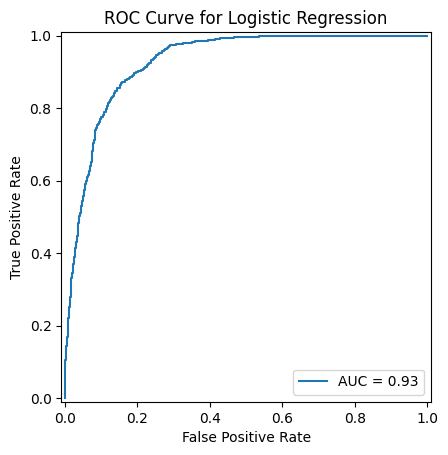

<Figure size 800x600 with 0 Axes>

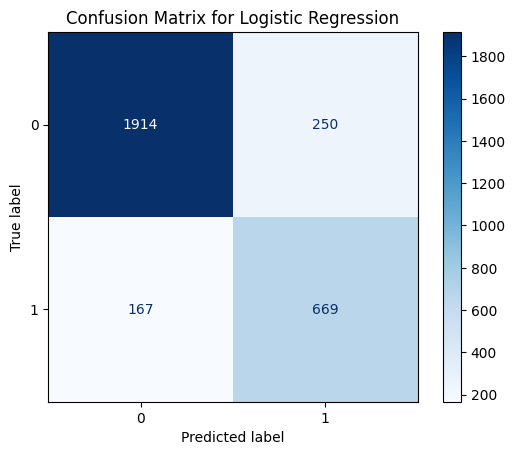

In [22]:
### 40% Threshold for Log Reg

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# Apply the best combination of hyperparameters
best_logreg = LogisticRegression(**best_params_logreg, max_iter=1000)
best_logreg.fit(X_train, y_train)

# Make predictions on the test set with a 40% threshold
y_pred_proba_logreg = best_logreg.predict_proba(X_test)[:, 1]
threshold = 0.4
y_pred_logreg = (y_pred_proba_logreg >= threshold).astype(int)

# Evaluate the Logistic Regression model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg)
recall_logreg = recall_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, y_pred_proba_logreg)

# Print the evaluation metrics
print(f'Accuracy: {accuracy_logreg:.4f}')
print(f'Precision: {precision_logreg:.4f}')
print(f'Recall: {recall_logreg:.4f}')
print(f'F1 Score: {f1_logreg:.4f}')
print(f'ROC AUC Score: {roc_auc_logreg:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred_logreg))

# Generate the ROC curve
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, y_pred_proba_logreg)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
roc_display_logreg = RocCurveDisplay(fpr=fpr_logreg, tpr=tpr_logreg, roc_auc=roc_auc_logreg)
roc_display_logreg.plot()
plt.title('ROC Curve for Logistic Regression')
plt.show()

# Generate the confusion matrix
cm_logreg = confusion_matrix(y_test, y_pred_logreg)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
cm_display_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=best_logreg.classes_)
cm_display_logreg.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Logistic Regression')
plt.show()


In [23]:
# Feature importance
coefficients = best_logreg.coef_[0]
feature_names = numerical_cols + list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_cols))

# Summarize coefficients for 'age-gender' feature
age_gender_indices = [i for i, feature in enumerate(feature_names) if 'age-gender' in feature]
age_gender_importance = sum(coefficients[age_gender_indices])

# Combine 'age-gender' importance with other features
final_feature_importance = {
    'age-gender': age_gender_importance,
    **{feature_names[i]: coefficients[i] for i in range(len(feature_names)) if i not in age_gender_indices}
}

# Convert to DataFrame for better readability
importance_df = pd.DataFrame(list(final_feature_importance.items()), columns=['Feature', 'Importance'])
print(importance_df)

                          Feature  Importance
0                      age-gender   -2.205609
1                  recency_months   13.817438
2                       frequency    4.561492
3  yes_response_per_emails_opened    7.579738
4        clicks_per_emails_opened  -11.681260
5           site_visits_per_month   -3.278254
